### Reference: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=HhIgGq3za0yh

Files already downloaded and verified


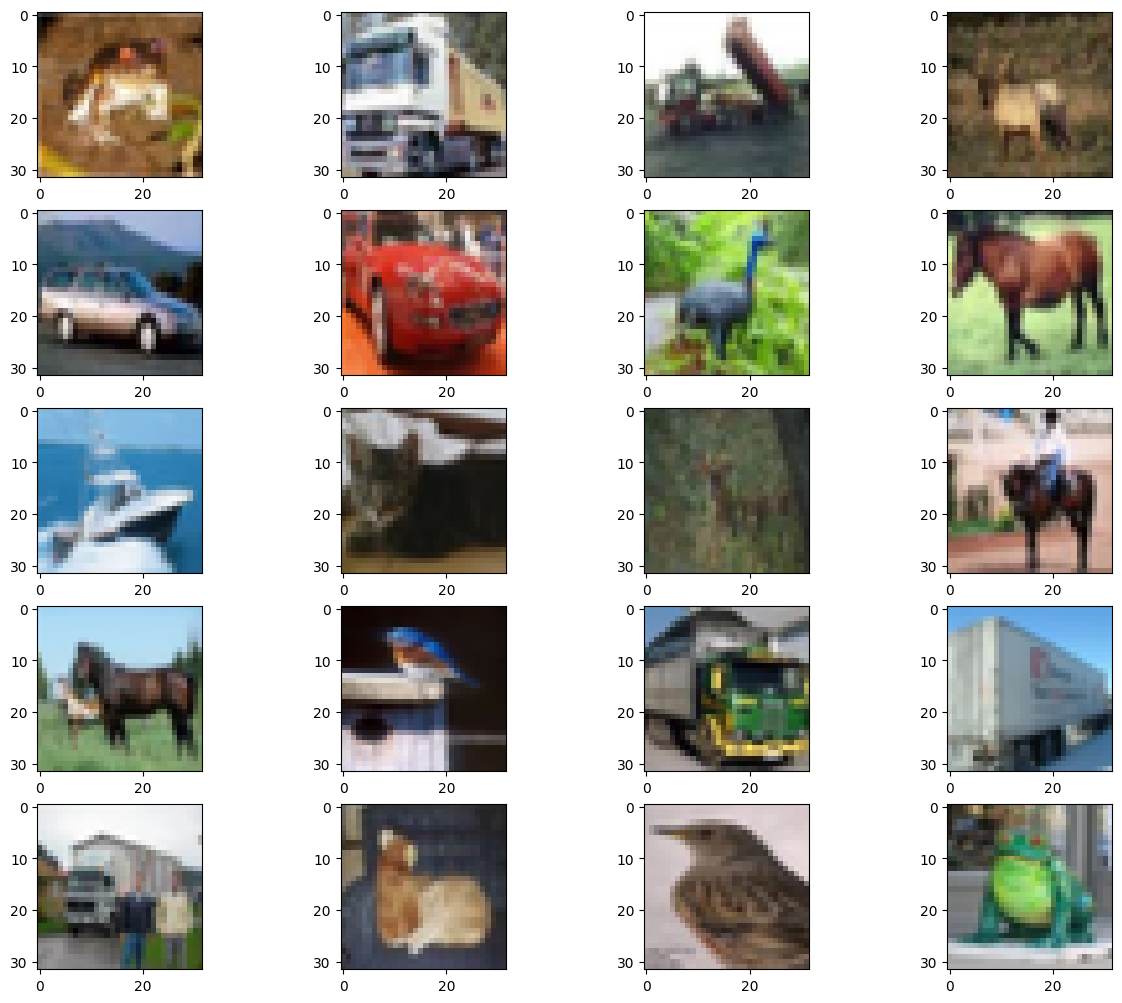

In [97]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.CIFAR10(root="./data", download=True)
show_images(data)

In [98]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.00001, end=0.005):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 100
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [99]:
from torchvision import transforms 
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    # Load the full CIFAR-10 training and test datasets
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transform)
    
    # Class index for 'airplane'
    class_index = 0  # 'airplane'
    
    # Get indices of all 'airplane' images in the training dataset
    train_class_indices = [i for i, label in enumerate(train_dataset.targets) if label == class_index]
    # Get indices of all 'airplane' images in the test dataset
    test_class_indices = [i for i, label in enumerate(test_dataset.targets) if label == class_index]
    
    # Create subsets from the full datasets including only 'airplane'
    train_class_dataset = Subset(train_dataset, train_class_indices)
    test_class_dataset = Subset(test_dataset, test_class_indices)
    
    # Combine the training and test class-specific datasets
    combined_class_dataset = ConcatDataset([train_class_dataset, test_class_dataset])
    
    return combined_class_dataset
    
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


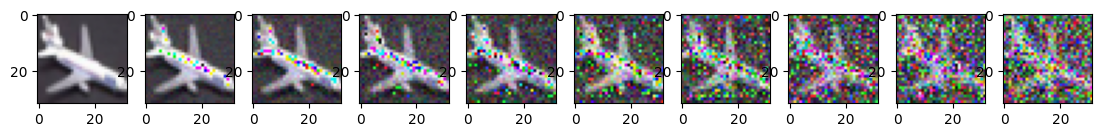

In [100]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [101]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        kernel_size = 2  # Changed from 4 to 2
        padding = 0  # Adjusted padding for new kernel size
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size, 2, padding)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size, 2, padding)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (32, 64, 128, 256, 512)
        up_channels = (512, 256, 128, 64, 32)
        out_dim = 3 
        time_emb_dim = 16

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  10393587


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=16, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=16, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kern

In [102]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [103]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()          

Epoch 0 | step 000 Loss: 0.8125810623168945 


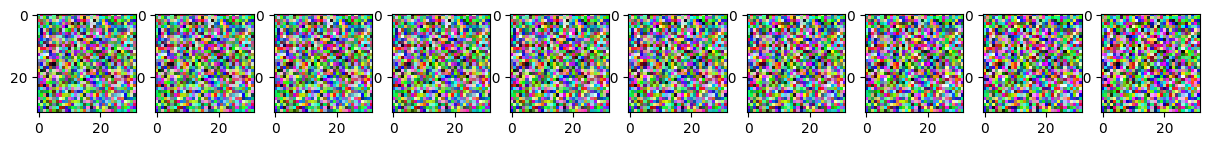

Epoch 5 | step 000 Loss: 0.29145097732543945 


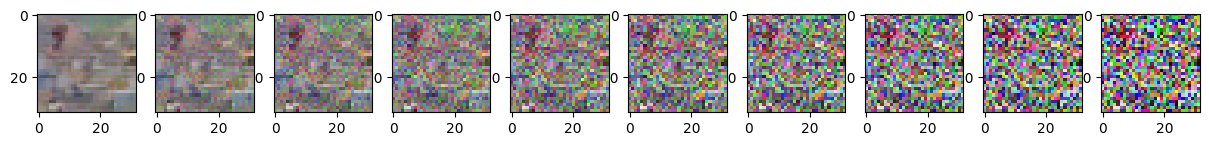

Epoch 10 | step 000 Loss: 0.2688053250312805 


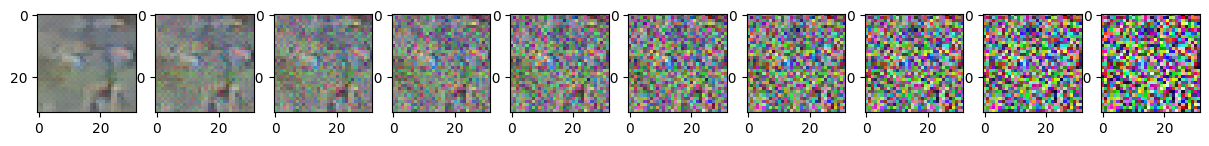

Epoch 15 | step 000 Loss: 0.24365484714508057 


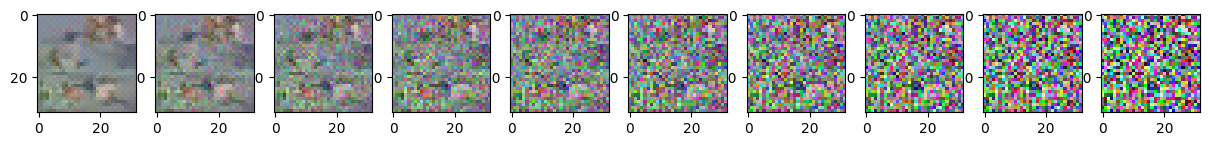

Epoch 20 | step 000 Loss: 0.26682281494140625 


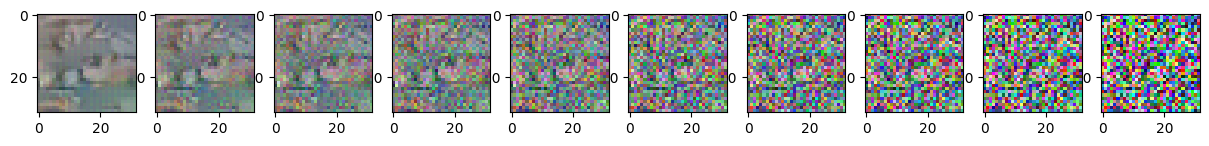

Epoch 25 | step 000 Loss: 0.29054948687553406 


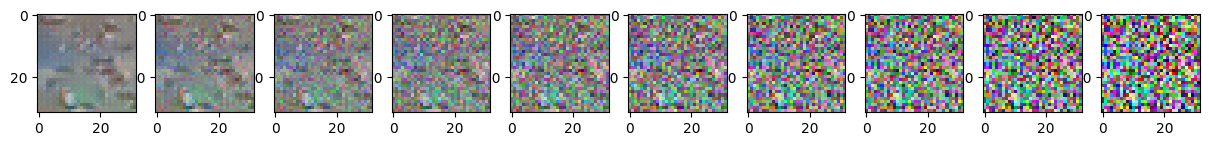

Epoch 30 | step 000 Loss: 0.2825047969818115 


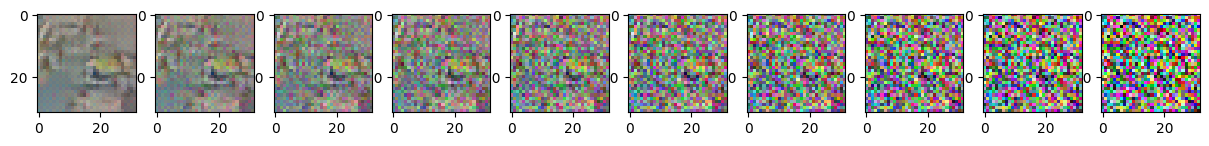

Epoch 35 | step 000 Loss: 0.26625919342041016 


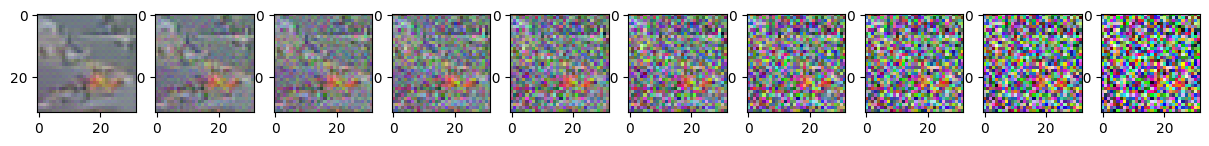

Epoch 40 | step 000 Loss: 0.25329527258872986 


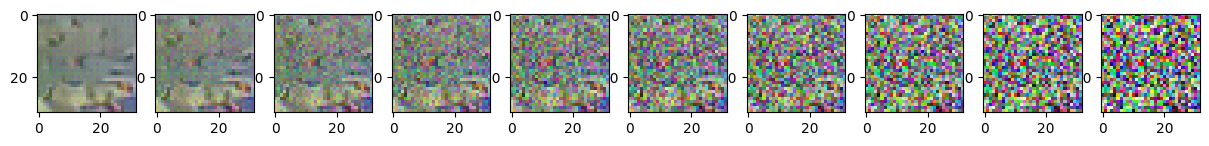

Epoch 45 | step 000 Loss: 0.2556585669517517 


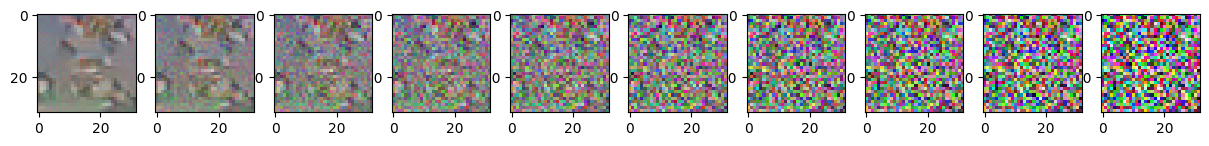

Epoch 50 | step 000 Loss: 0.23847338557243347 


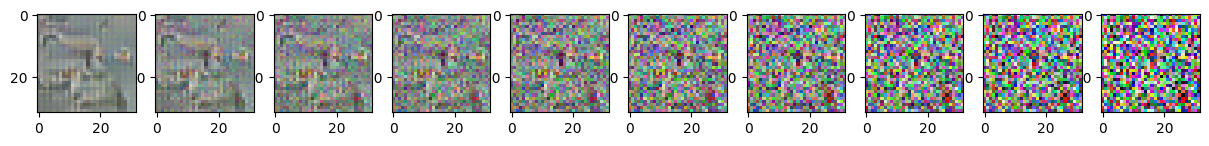

Epoch 55 | step 000 Loss: 0.24229896068572998 


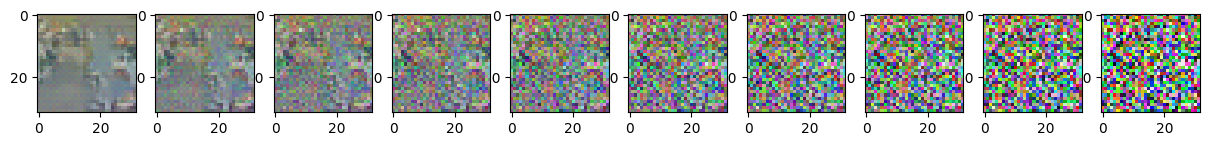

Epoch 60 | step 000 Loss: 0.24765042960643768 


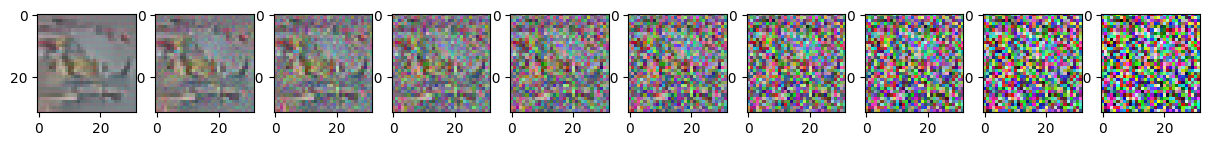

Epoch 65 | step 000 Loss: 0.26796942949295044 


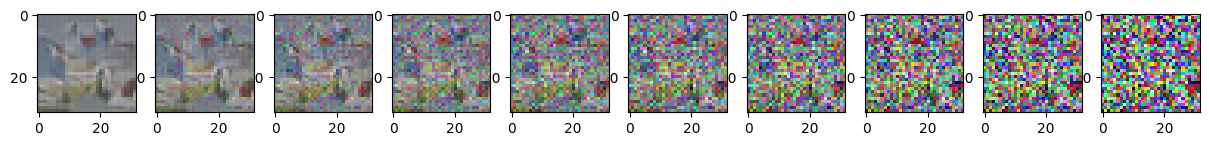

Epoch 70 | step 000 Loss: 0.2518478333950043 


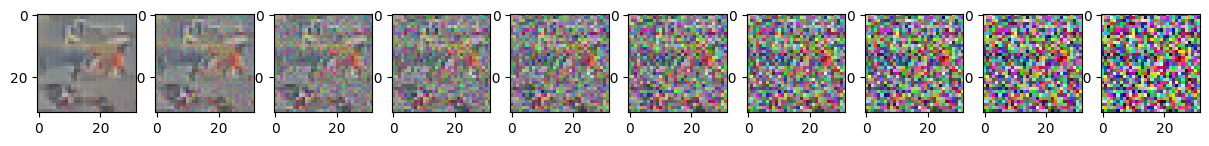

Epoch 75 | step 000 Loss: 0.24715428054332733 


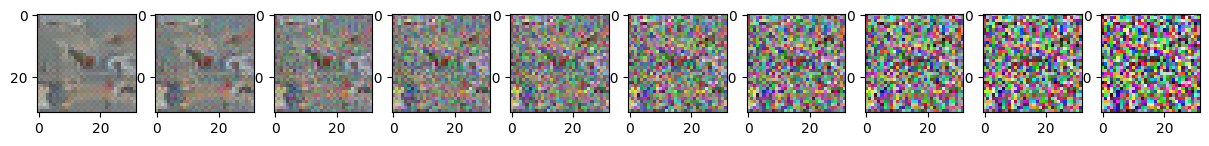

Epoch 80 | step 000 Loss: 0.2627694010734558 


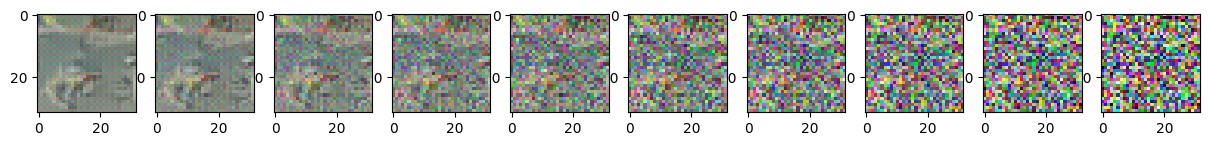

Epoch 85 | step 000 Loss: 0.25796008110046387 


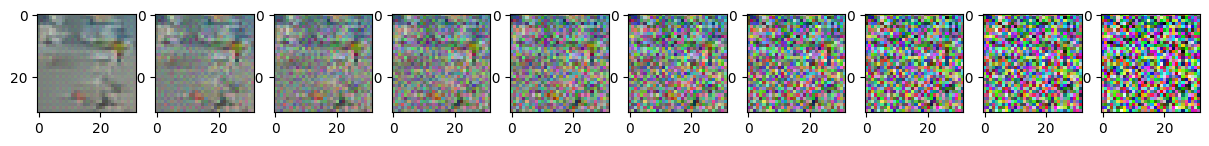

Epoch 90 | step 000 Loss: 0.2485620379447937 


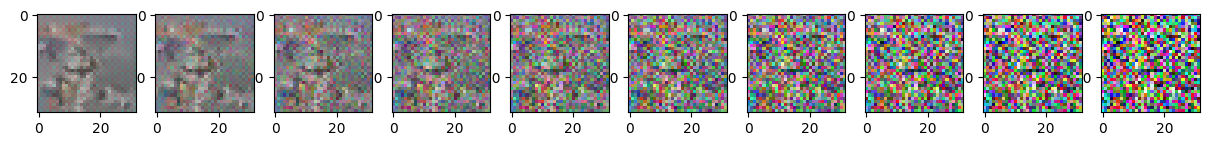

Epoch 95 | step 000 Loss: 0.23818755149841309 


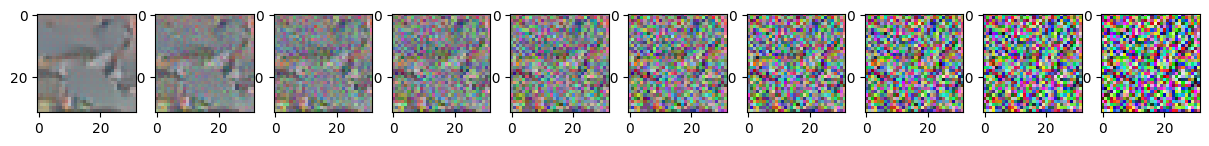

Epoch 100 | step 000 Loss: 0.23787550628185272 


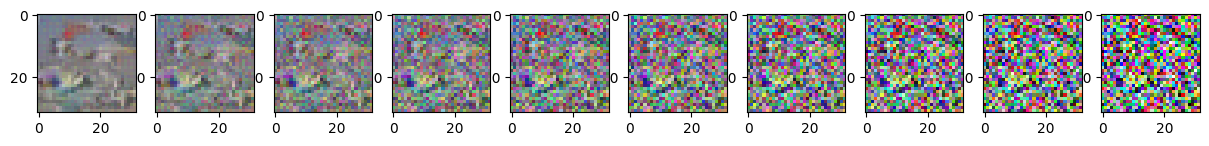

Epoch 105 | step 000 Loss: 0.2345380187034607 


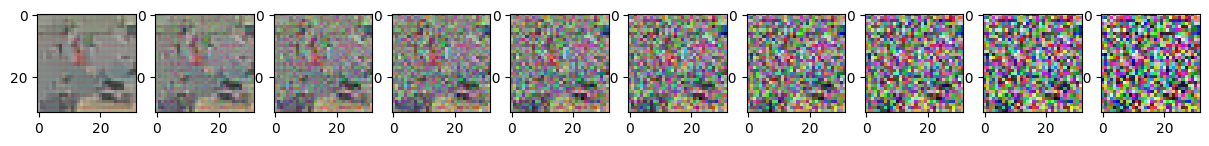

Epoch 110 | step 000 Loss: 0.2424410581588745 


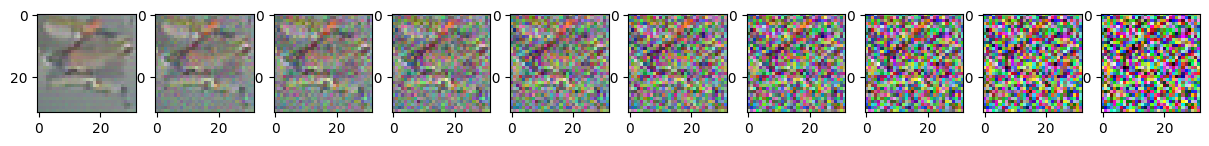

Epoch 115 | step 000 Loss: 0.25505638122558594 


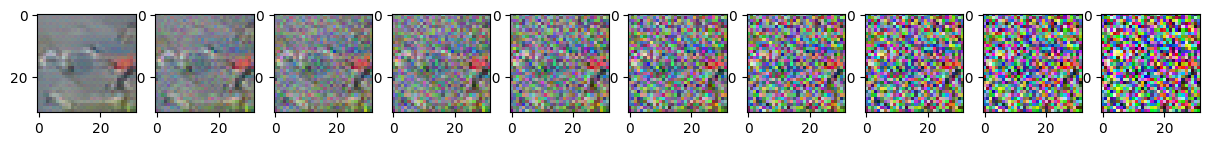

Epoch 120 | step 000 Loss: 0.2354593724012375 


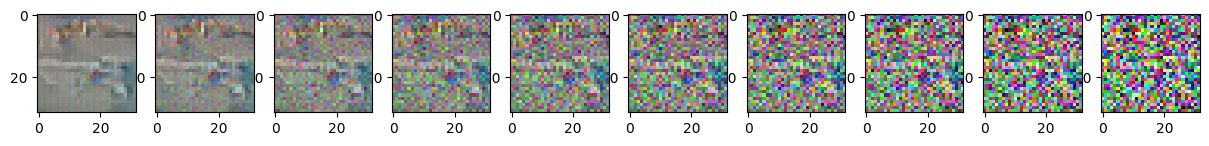

Epoch 125 | step 000 Loss: 0.2365422248840332 


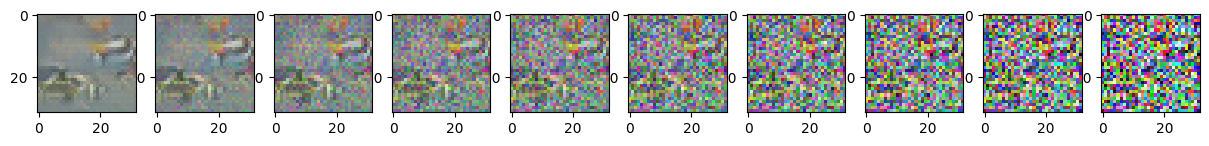

Epoch 130 | step 000 Loss: 0.2661382555961609 


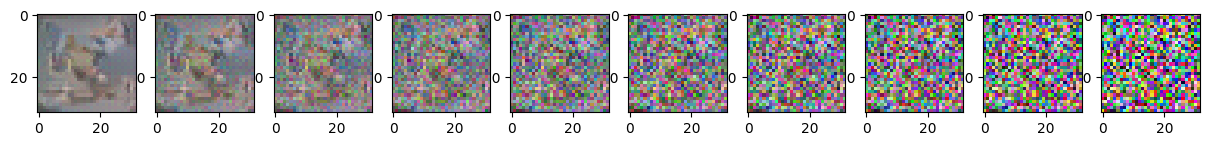

Epoch 135 | step 000 Loss: 0.2597167491912842 


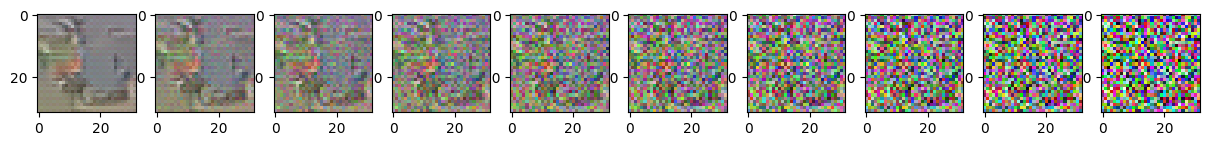

Epoch 140 | step 000 Loss: 0.24744543433189392 


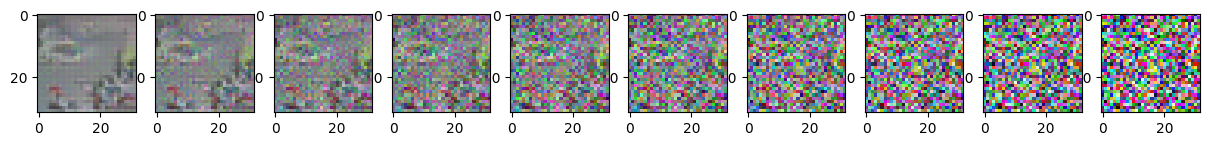

Epoch 145 | step 000 Loss: 0.23144182562828064 


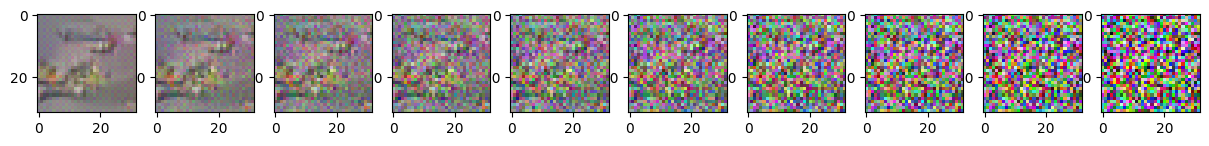

Epoch 150 | step 000 Loss: 0.24362394213676453 


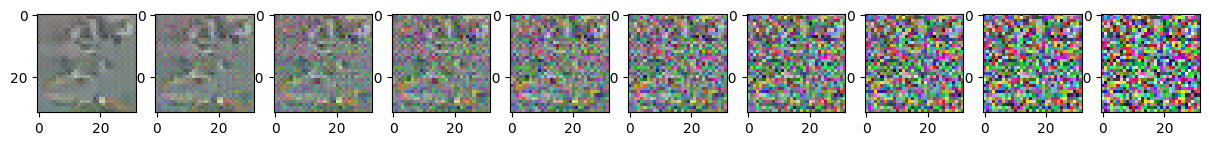

Epoch 155 | step 000 Loss: 0.2496815323829651 


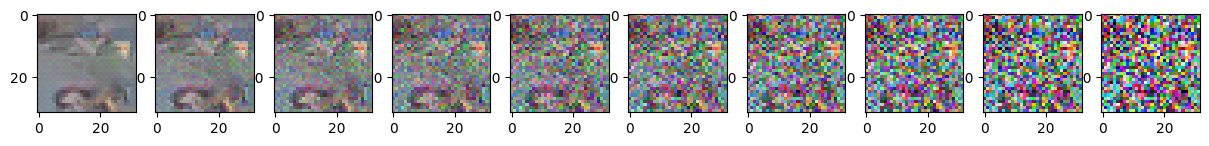

Epoch 160 | step 000 Loss: 0.2590150535106659 


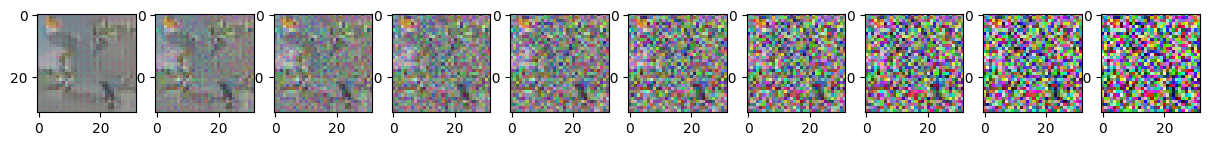

Epoch 165 | step 000 Loss: 0.2449573129415512 


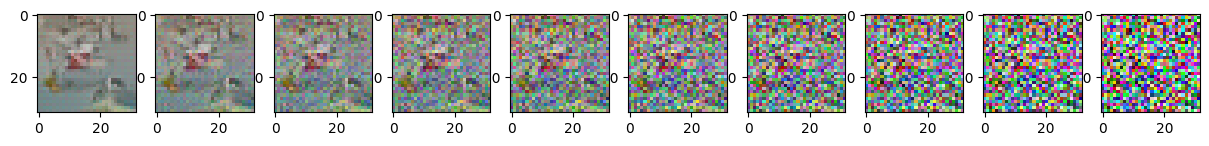

Epoch 170 | step 000 Loss: 0.20672814548015594 


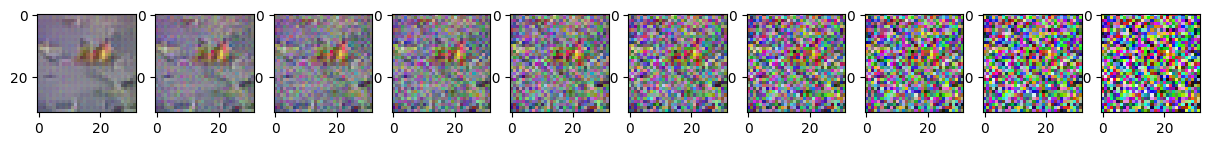

Epoch 175 | step 000 Loss: 0.2509152293205261 


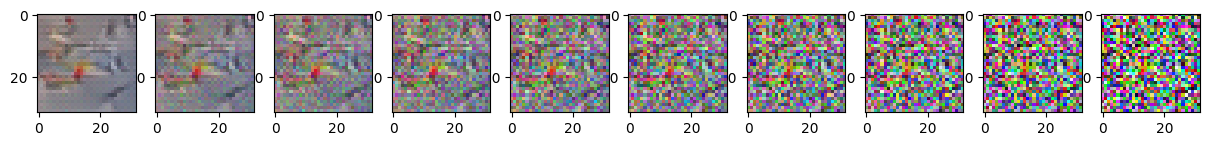

Epoch 180 | step 000 Loss: 0.2323443591594696 


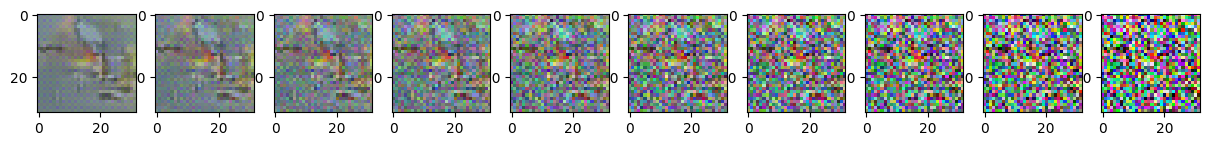

Epoch 185 | step 000 Loss: 0.2537226378917694 


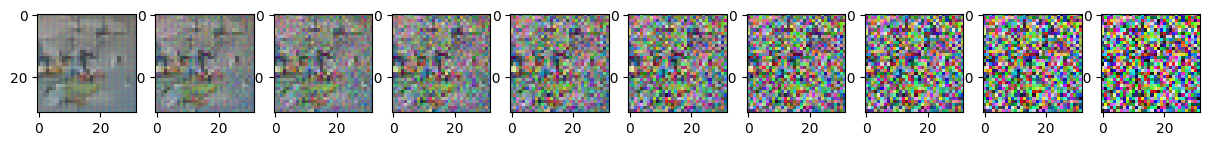

Epoch 190 | step 000 Loss: 0.2563156485557556 


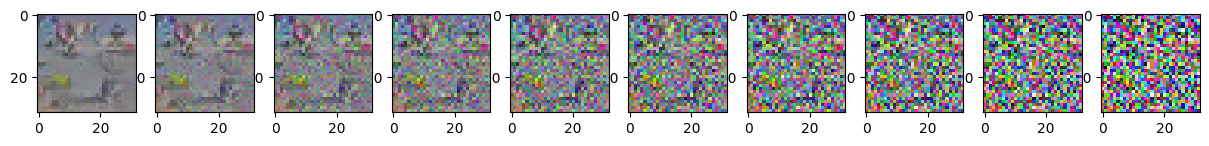

Epoch 195 | step 000 Loss: 0.24905803799629211 


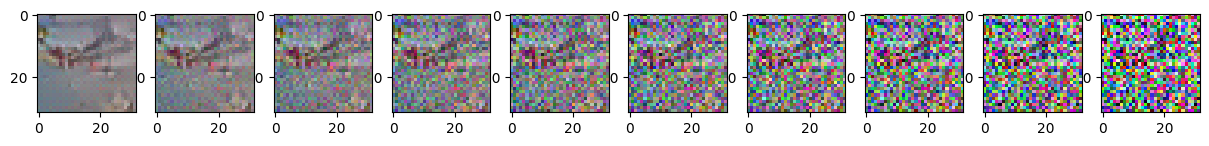

Epoch 200 | step 000 Loss: 0.23452425003051758 


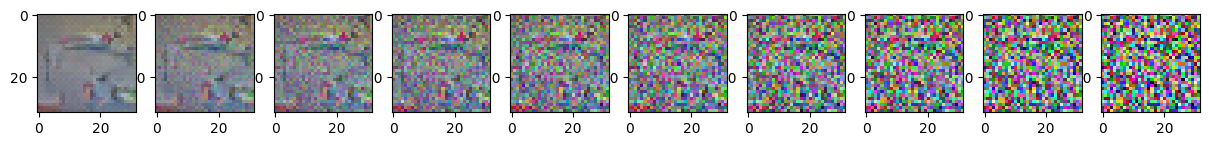

Epoch 205 | step 000 Loss: 0.23328463733196259 


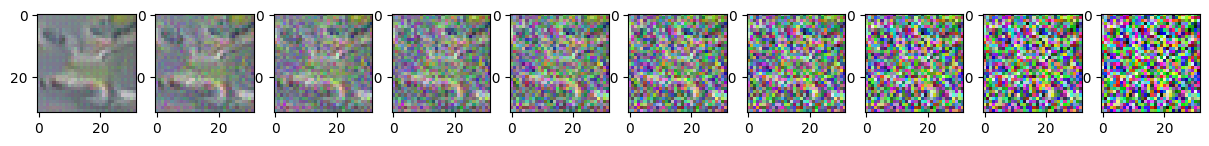

Epoch 210 | step 000 Loss: 0.2555048167705536 


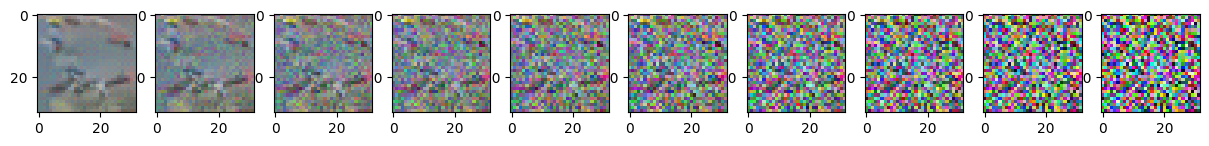

Epoch 215 | step 000 Loss: 0.22918865084648132 


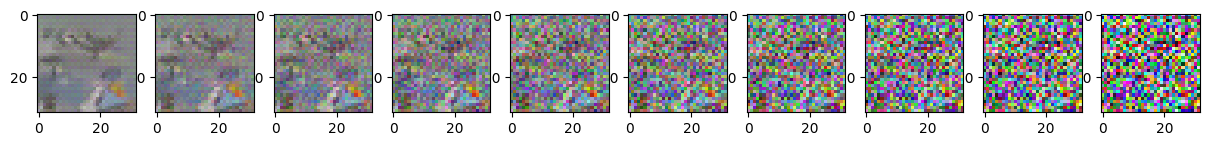

Epoch 220 | step 000 Loss: 0.23471519351005554 


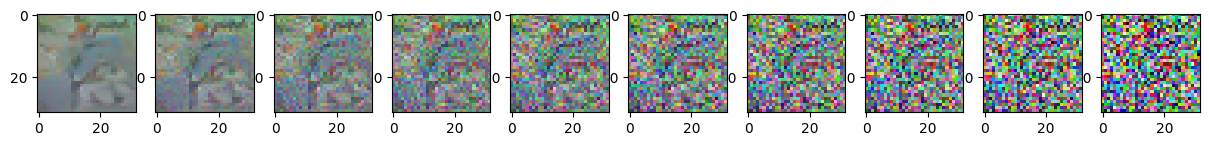

Epoch 225 | step 000 Loss: 0.23166358470916748 


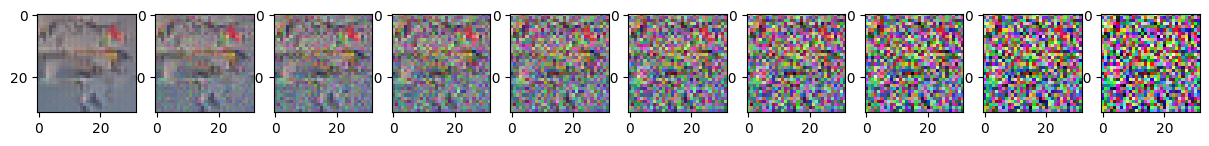

Epoch 230 | step 000 Loss: 0.24183818697929382 


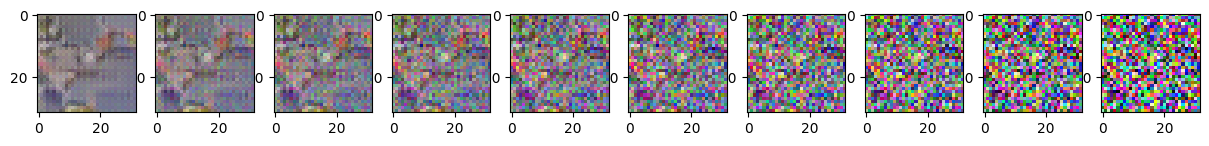

Epoch 235 | step 000 Loss: 0.23646286129951477 


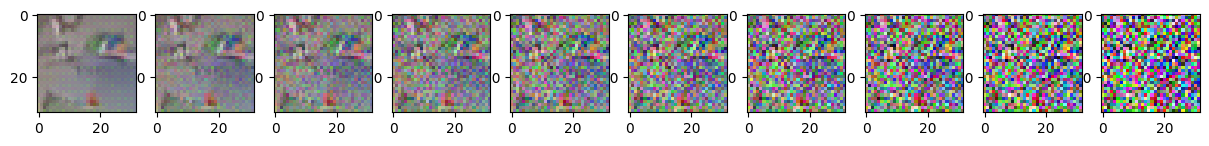

Epoch 240 | step 000 Loss: 0.23986856639385223 


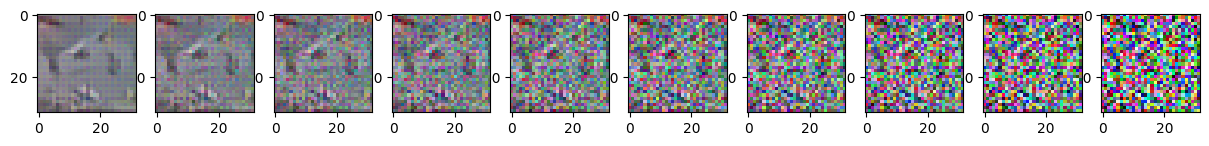

Epoch 245 | step 000 Loss: 0.2452692985534668 


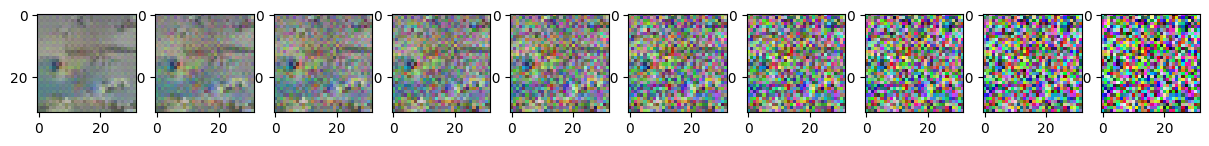

Epoch 250 | step 000 Loss: 0.23487025499343872 


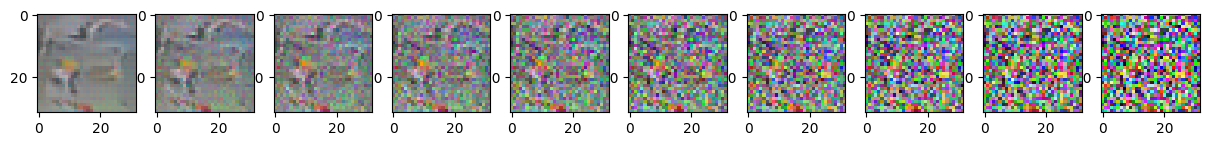

Epoch 255 | step 000 Loss: 0.22721873223781586 


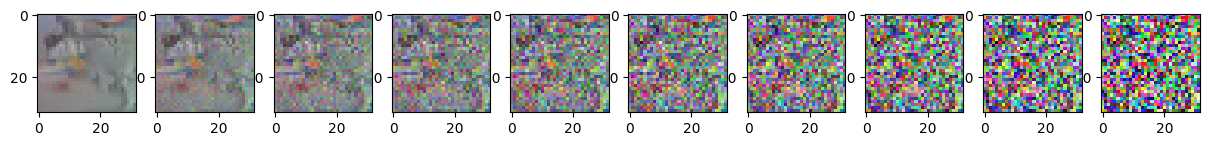

Epoch 260 | step 000 Loss: 0.23304855823516846 


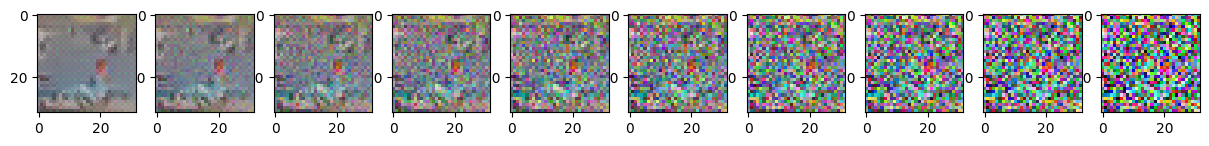

Epoch 265 | step 000 Loss: 0.24327543377876282 


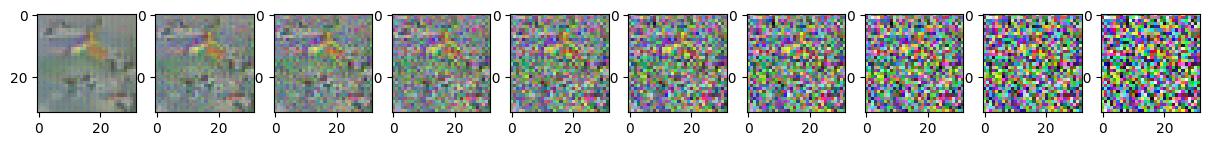

Epoch 270 | step 000 Loss: 0.23862871527671814 


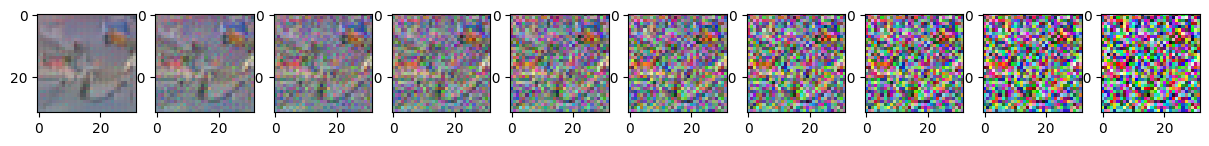

Epoch 275 | step 000 Loss: 0.2507266402244568 


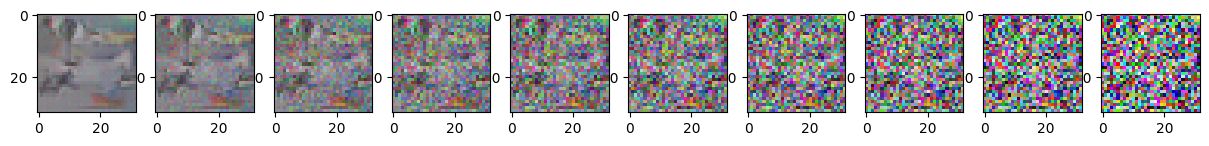

Epoch 280 | step 000 Loss: 0.24465975165367126 


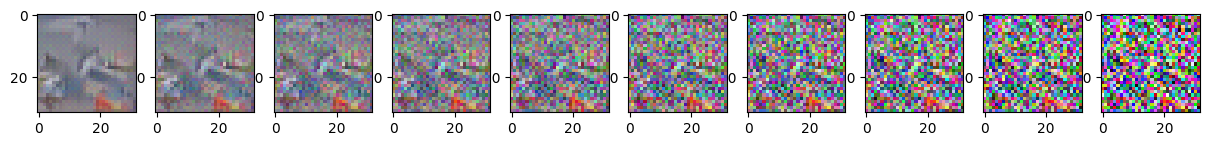

Epoch 285 | step 000 Loss: 0.2462187111377716 


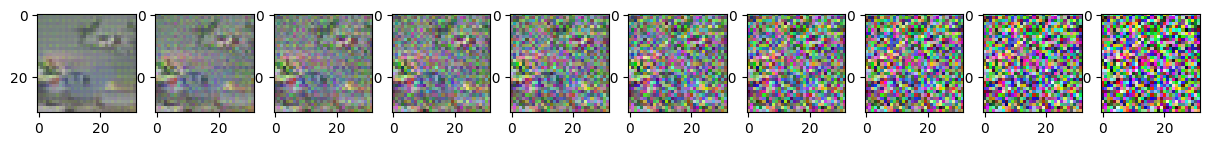

Epoch 290 | step 000 Loss: 0.24048933386802673 


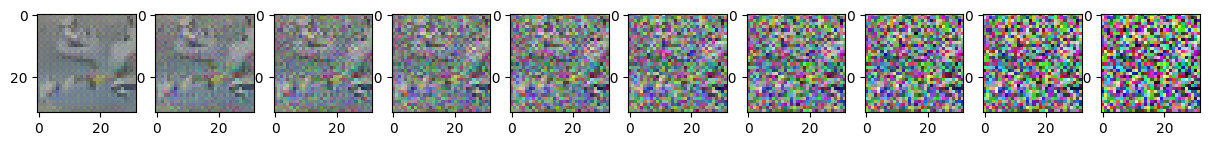

Epoch 295 | step 000 Loss: 0.23732838034629822 


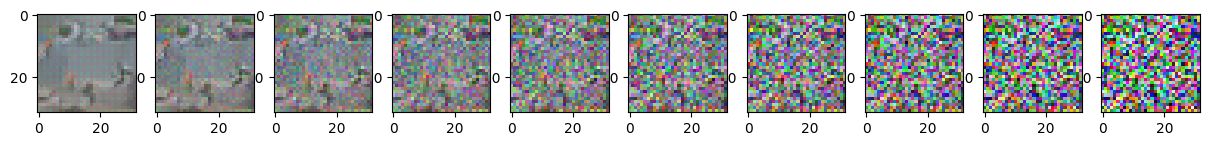

Epoch 300 | step 000 Loss: 0.24752351641654968 


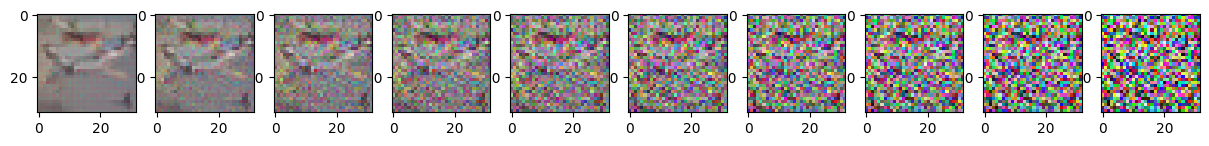

Epoch 305 | step 000 Loss: 0.2476705014705658 


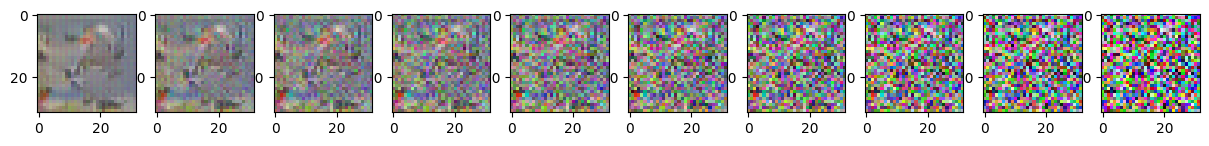

Epoch 310 | step 000 Loss: 0.2446335256099701 


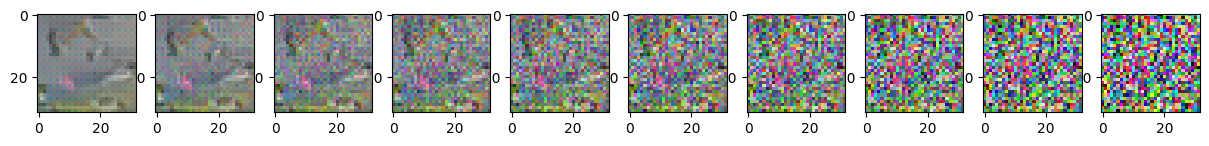

Epoch 315 | step 000 Loss: 0.24446146190166473 


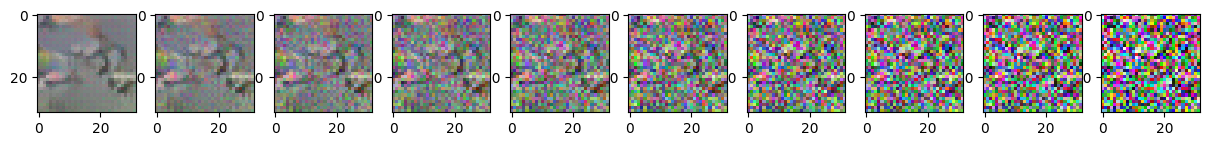

Epoch 320 | step 000 Loss: 0.24413177371025085 


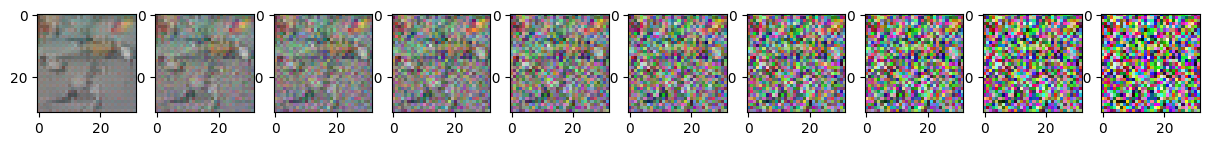

Epoch 325 | step 000 Loss: 0.2626517415046692 


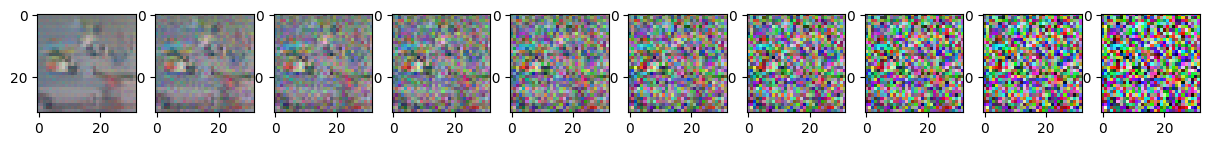

Epoch 330 | step 000 Loss: 0.24937120079994202 


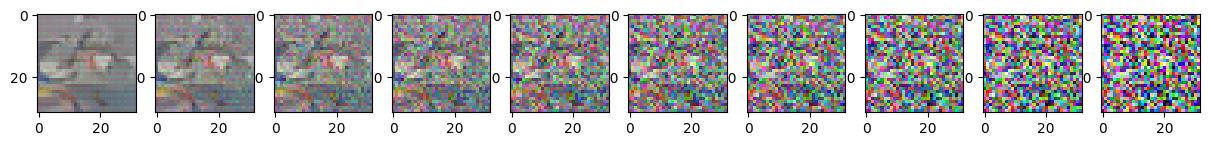

Epoch 335 | step 000 Loss: 0.2204379290342331 


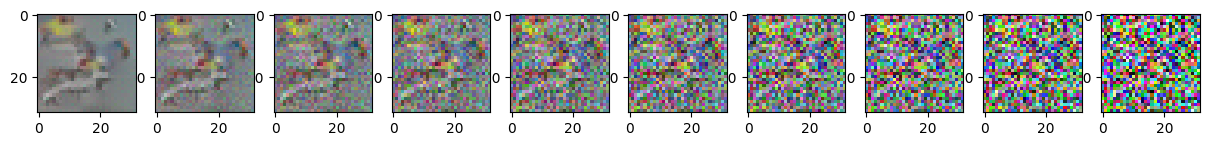

Epoch 340 | step 000 Loss: 0.24390193819999695 


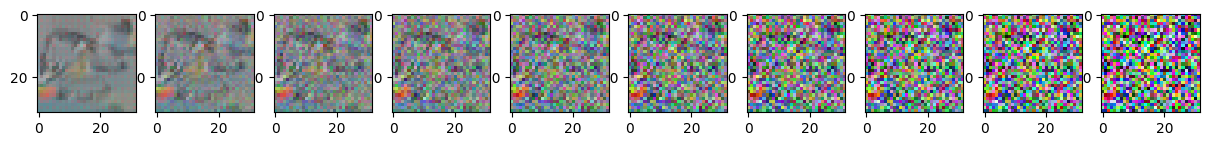

Epoch 345 | step 000 Loss: 0.2527388632297516 


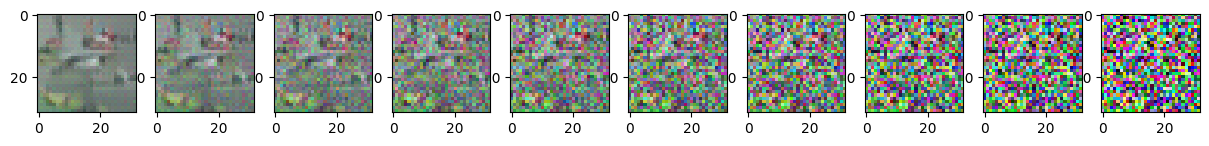

Epoch 350 | step 000 Loss: 0.2471250742673874 


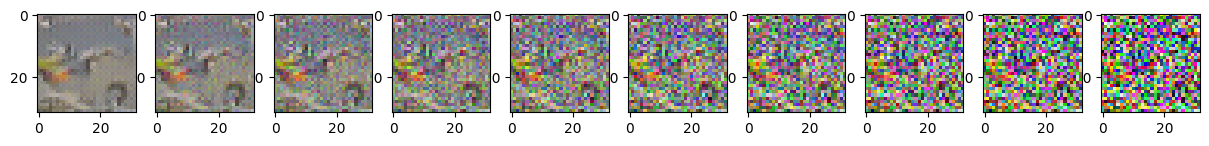

Epoch 355 | step 000 Loss: 0.2380758374929428 


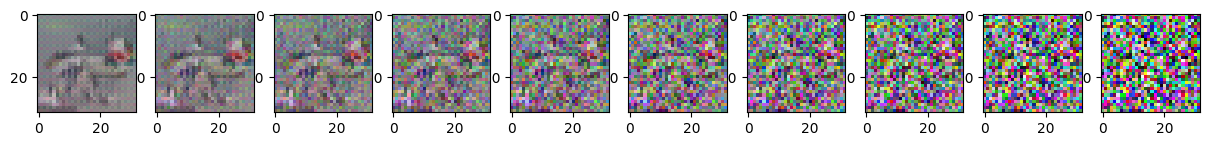

Epoch 360 | step 000 Loss: 0.2764356732368469 


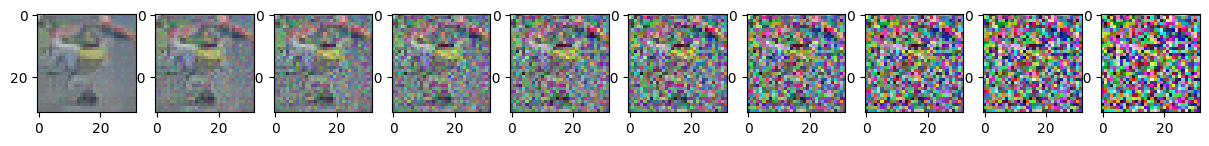

Epoch 365 | step 000 Loss: 0.23536813259124756 


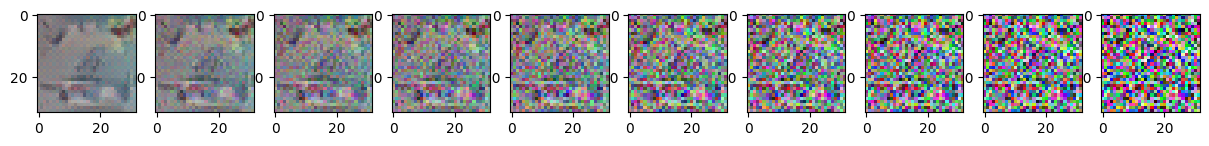

Epoch 370 | step 000 Loss: 0.23463156819343567 


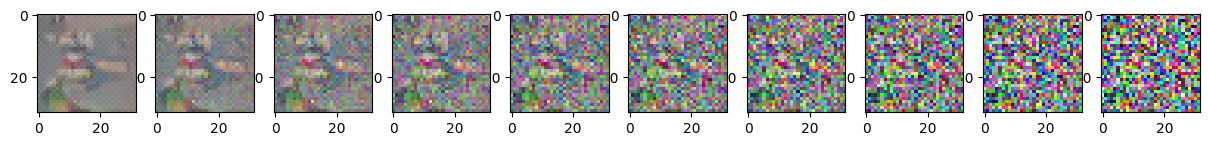

Epoch 375 | step 000 Loss: 0.25455009937286377 


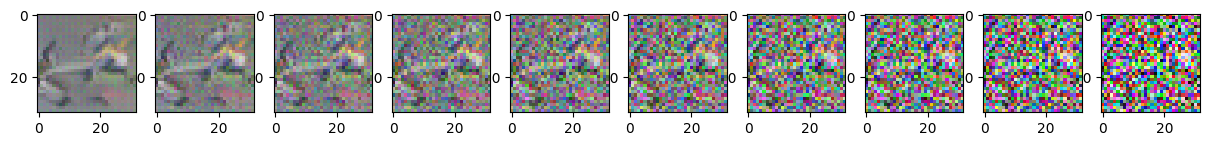

Epoch 380 | step 000 Loss: 0.23364779353141785 


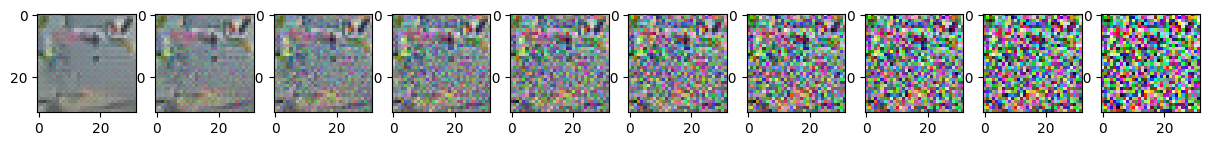

Epoch 385 | step 000 Loss: 0.24026070535182953 


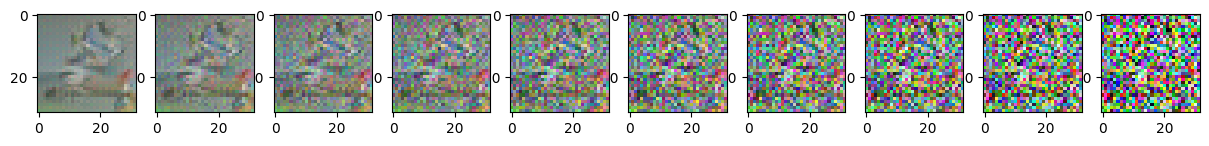

Epoch 390 | step 000 Loss: 0.2524510622024536 


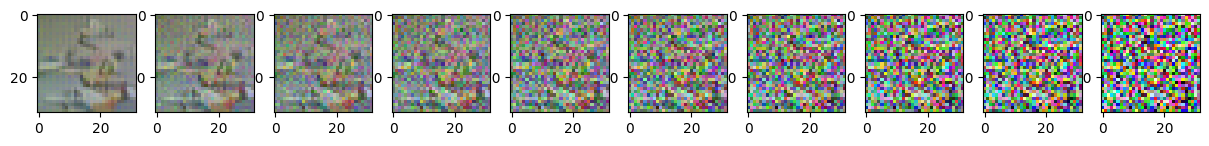

Epoch 395 | step 000 Loss: 0.24174901843070984 


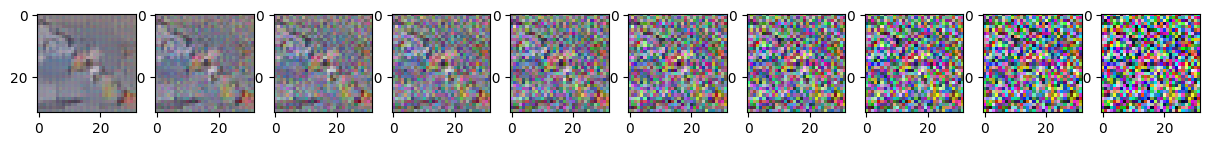

Epoch 400 | step 000 Loss: 0.2345578521490097 


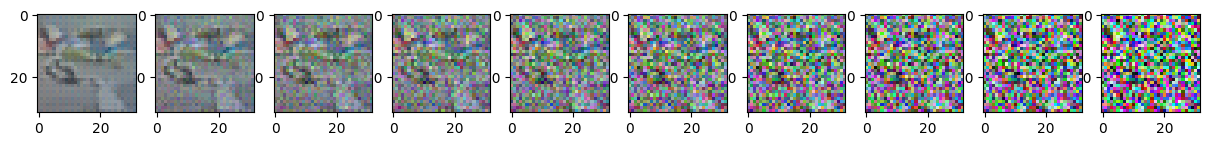

Epoch 405 | step 000 Loss: 0.23772266507148743 


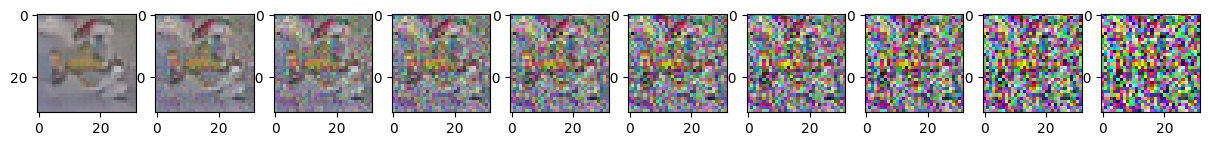

Epoch 410 | step 000 Loss: 0.23572146892547607 


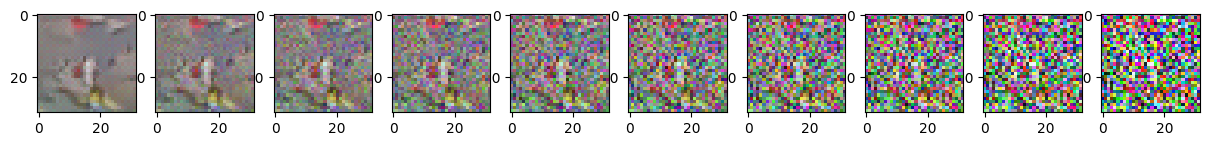

Epoch 415 | step 000 Loss: 0.2503621280193329 


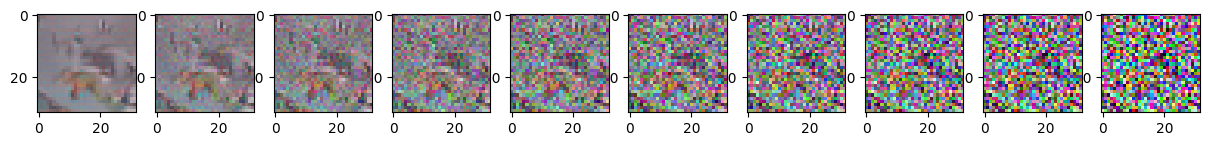

Epoch 420 | step 000 Loss: 0.23659741878509521 


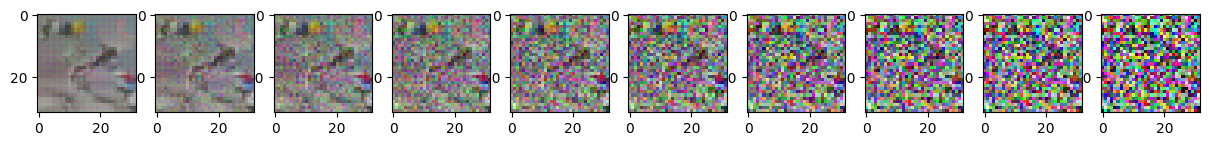

Epoch 425 | step 000 Loss: 0.24988028407096863 


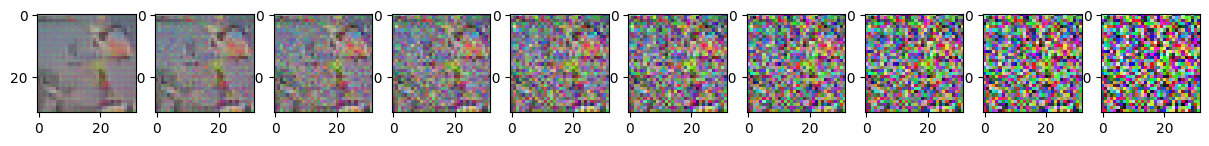

Epoch 430 | step 000 Loss: 0.2409122884273529 


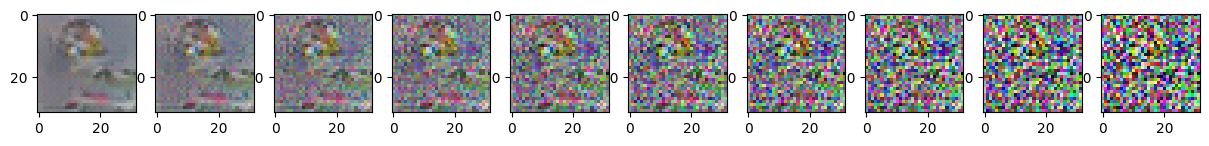

Epoch 435 | step 000 Loss: 0.22866939008235931 


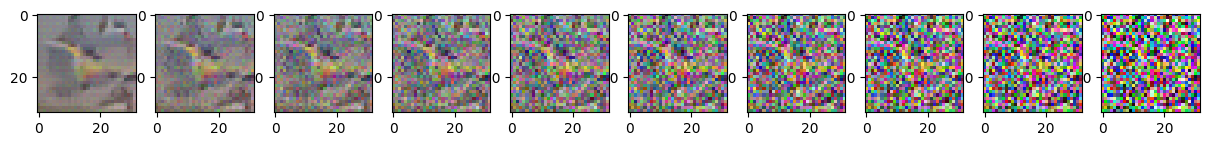

Epoch 440 | step 000 Loss: 0.2235790342092514 


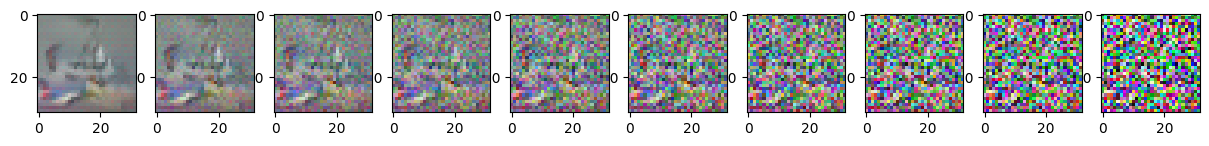

Epoch 445 | step 000 Loss: 0.23618292808532715 


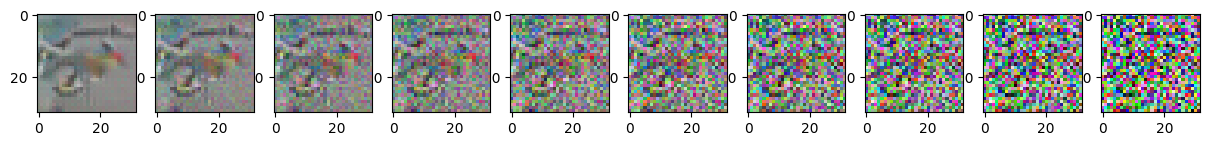

Epoch 450 | step 000 Loss: 0.2328324019908905 


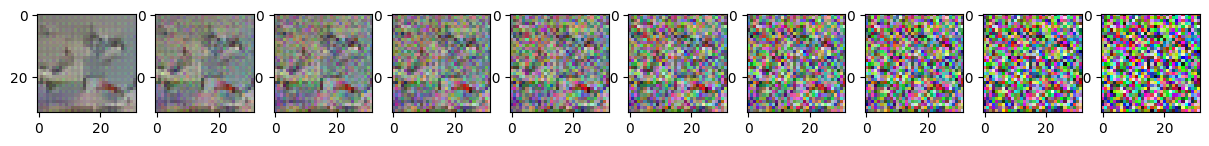

Epoch 455 | step 000 Loss: 0.22217492759227753 


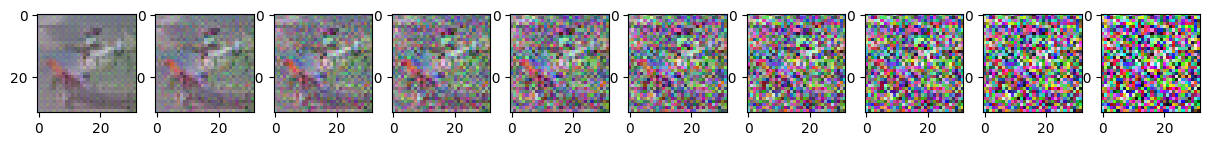

Epoch 460 | step 000 Loss: 0.2298157811164856 


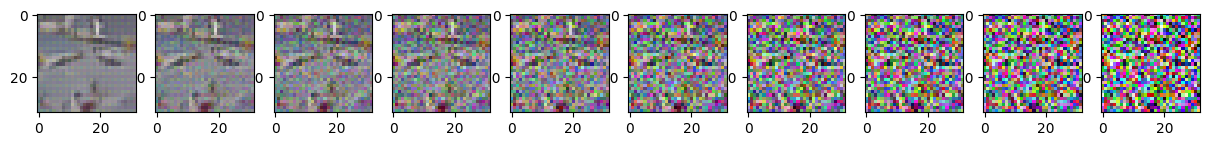

Epoch 465 | step 000 Loss: 0.24792979657649994 


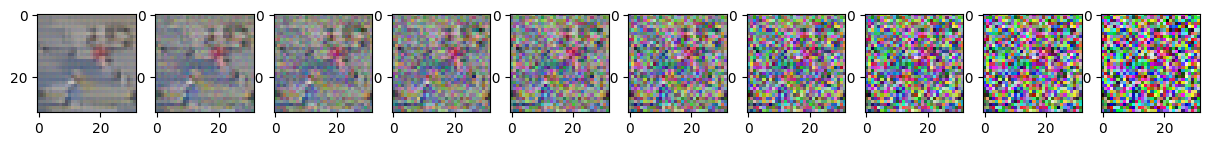

Epoch 470 | step 000 Loss: 0.22441843152046204 


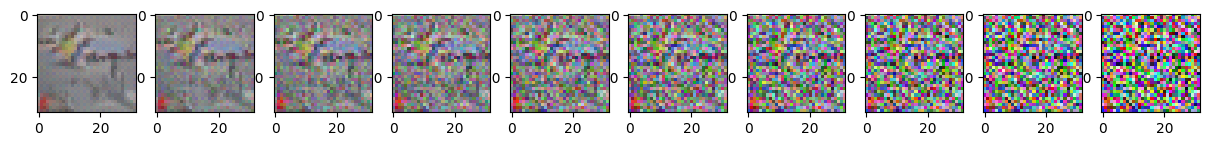

Epoch 475 | step 000 Loss: 0.23539528250694275 


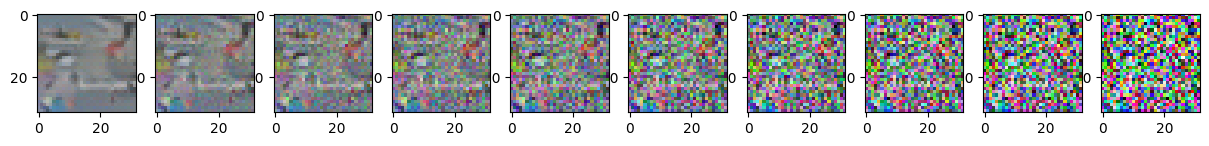

Epoch 480 | step 000 Loss: 0.22607974708080292 


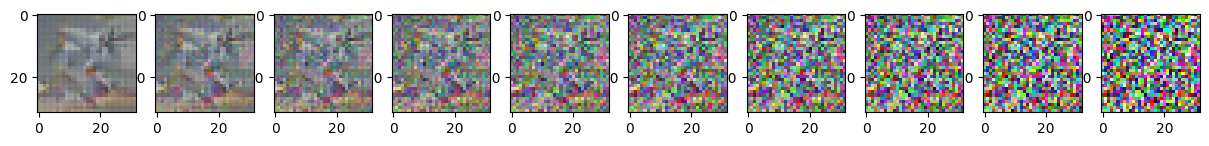

Epoch 485 | step 000 Loss: 0.23766551911830902 


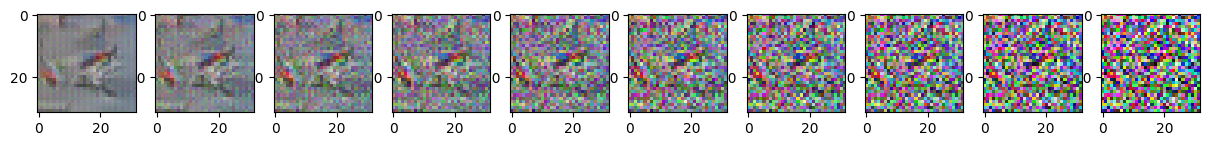

Epoch 490 | step 000 Loss: 0.24104660749435425 


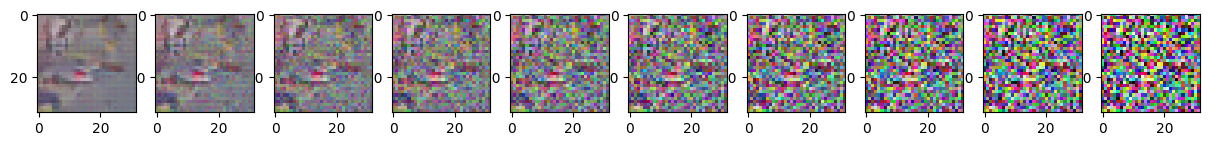

Epoch 495 | step 000 Loss: 0.22427141666412354 


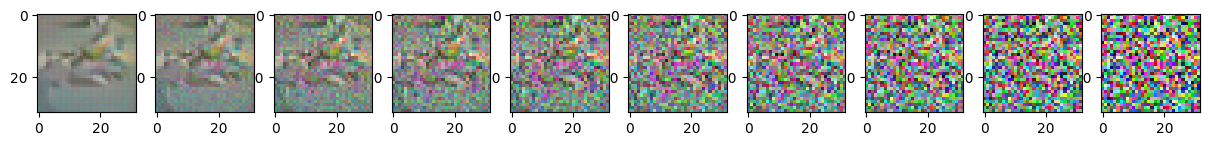

Epoch 500 | step 000 Loss: 0.24462029337882996 


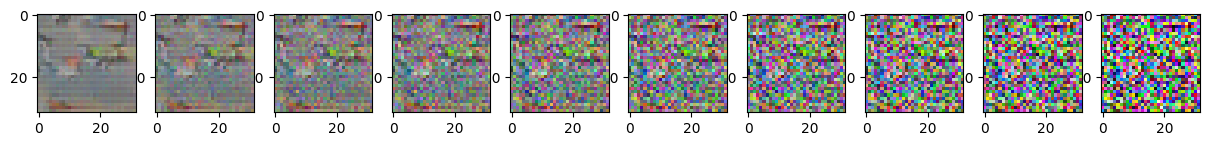

Epoch 505 | step 000 Loss: 0.23308120667934418 


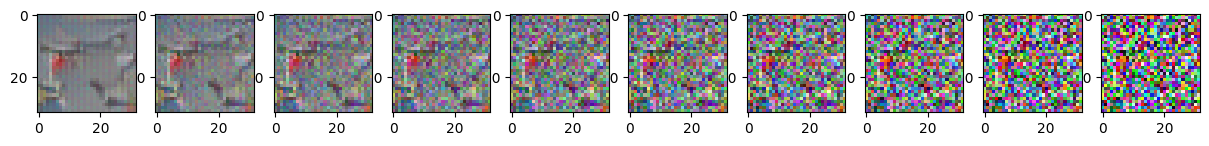

Epoch 510 | step 000 Loss: 0.22299163043498993 


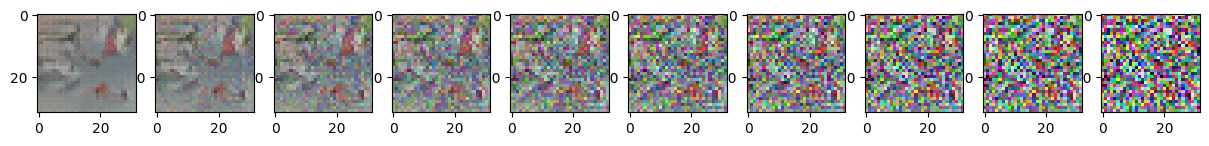

Epoch 515 | step 000 Loss: 0.238683819770813 


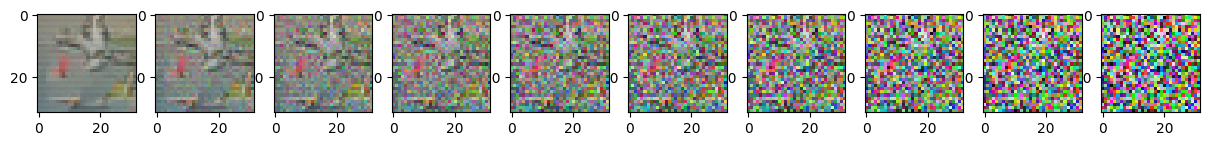

Epoch 520 | step 000 Loss: 0.24730192124843597 


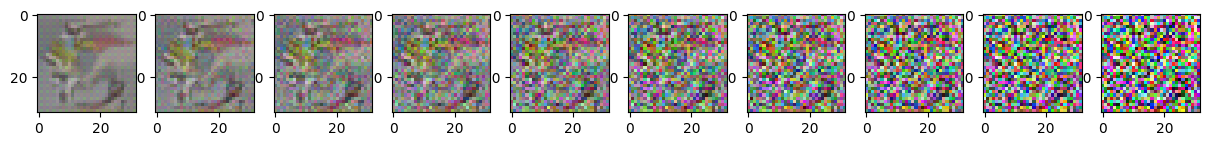

Epoch 525 | step 000 Loss: 0.22309283912181854 


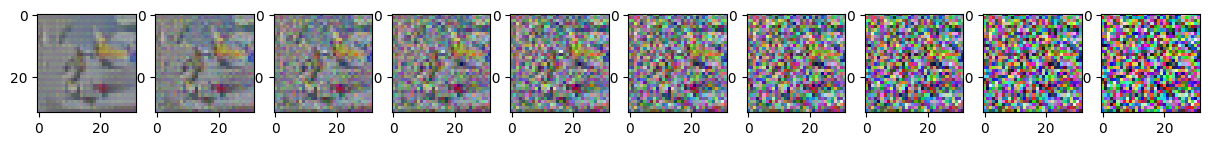

Epoch 530 | step 000 Loss: 0.23979954421520233 


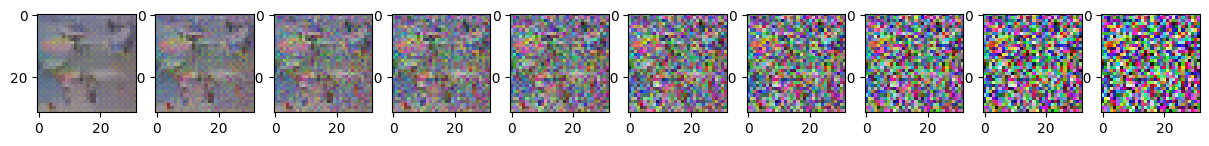

Epoch 535 | step 000 Loss: 0.24606578052043915 


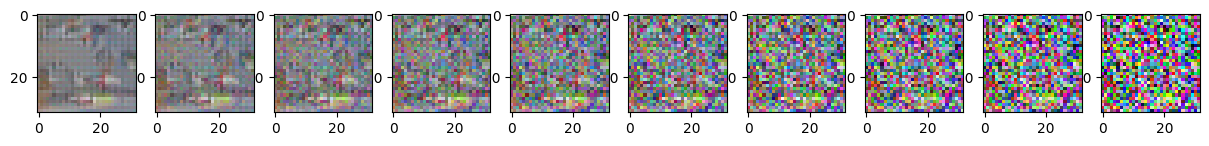

Epoch 540 | step 000 Loss: 0.23029586672782898 


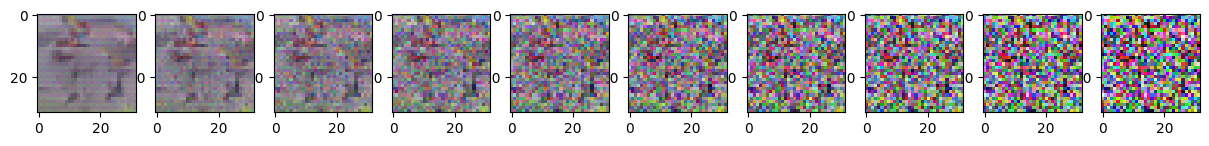

Epoch 545 | step 000 Loss: 0.24063050746917725 


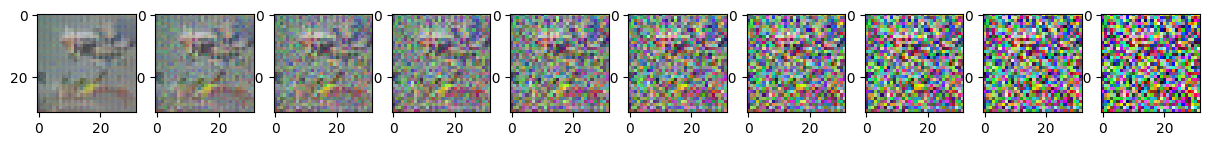

Epoch 550 | step 000 Loss: 0.2273920476436615 


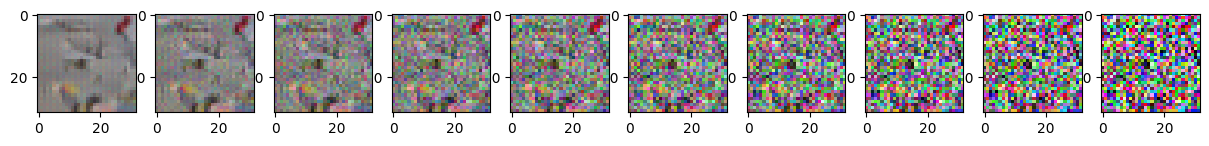

Epoch 555 | step 000 Loss: 0.23757778108119965 


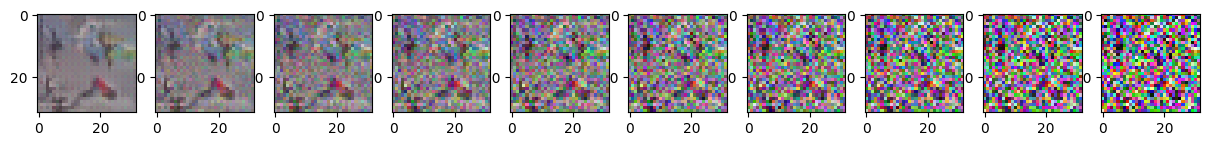

Epoch 560 | step 000 Loss: 0.2368190735578537 


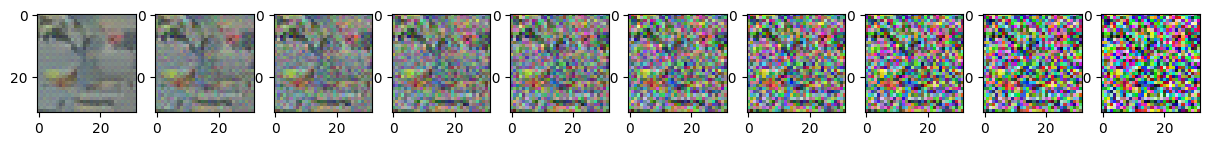

Epoch 565 | step 000 Loss: 0.2429584115743637 


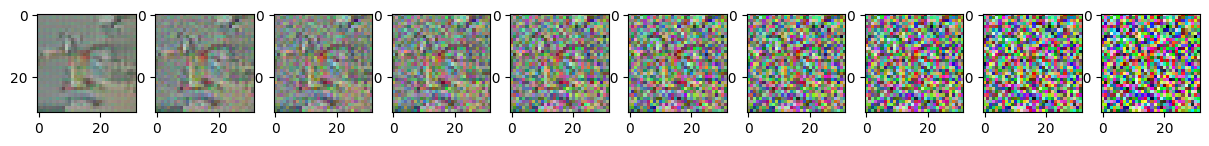

Epoch 570 | step 000 Loss: 0.21975068747997284 


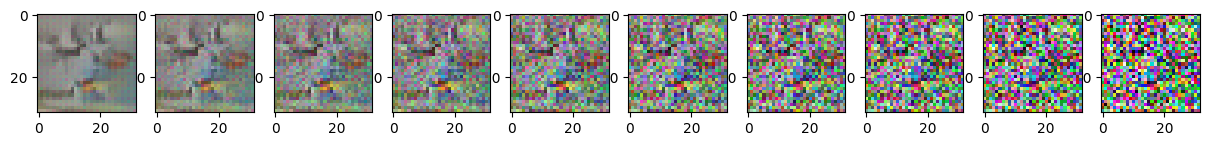

Epoch 575 | step 000 Loss: 0.22536294162273407 


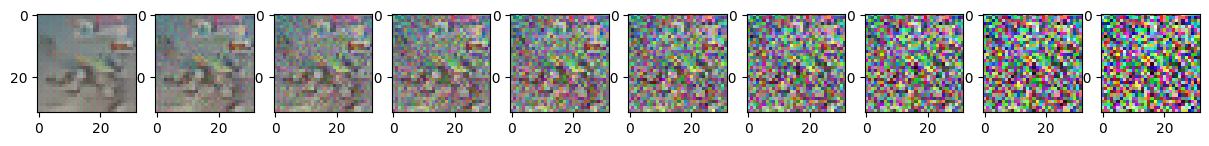

Epoch 580 | step 000 Loss: 0.2385348081588745 


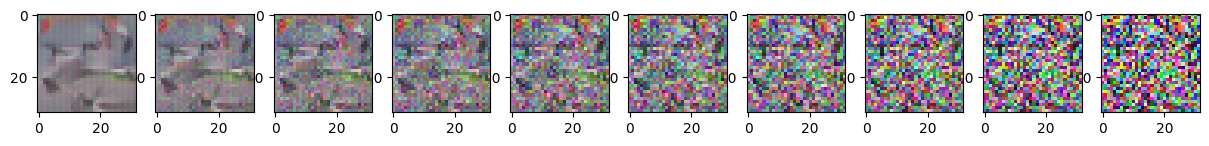

Epoch 585 | step 000 Loss: 0.21445433795452118 


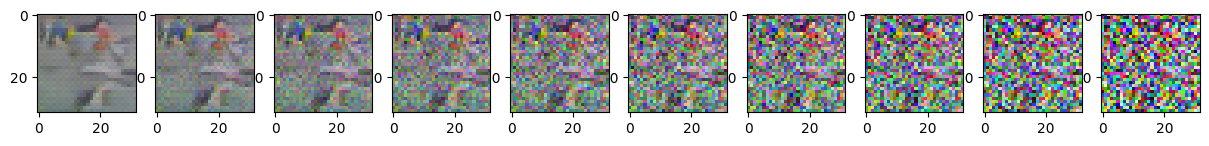

Epoch 590 | step 000 Loss: 0.22925004363059998 


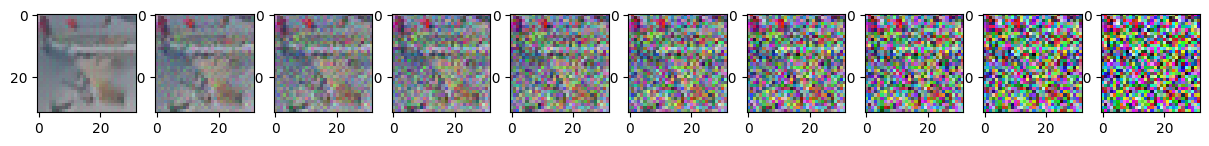

Epoch 595 | step 000 Loss: 0.21797707676887512 


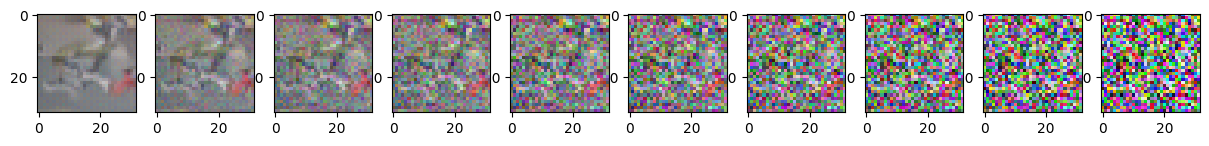

In [104]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.005)
epochs = 600 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()